In [1]:
import pandas as pd
import cv2
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
import tensorflow as tf
# import tensorflow.compat.v1 as tf
from tensorflow import keras
import numpy as np
from keras.preprocessing.sequence import pad_sequences
import os
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import OrderedDict
# from tensorflow.python.ops import math_ops
import tensorflow.keras.backend as kb
from load_data import Files_Load, Boxes, test_split_norm_abnorm, norm_train_max_min
from tensorflow_addons.utils.ensure_tf_install import _check_tf_version
_check_tf_version()
from tensorflow_addons import losses

from sklearn.cluster import KMeans
from Persistence1D.python.persistence1d import RunPersistence
# Note that I needed to move unionfind file for some reason into current directory
# Or I could have cd into where file was at and tried to use it 


Using TensorFlow backend.


In [2]:
from Persistence1D.python.persistence1d import RunPersistence
# from persistence1d import RunPersistence

In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


In [4]:
# tf.test.is_gpu_available()

tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [5]:
# gpus = tf.config.experimental.list_physical_devices('GPU')
# if gpus:
#   # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
#   try:
#     tf.config.experimental.set_virtual_device_configuration(
#         gpus[0],
#         [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=5500)])
#     logical_gpus = tf.config.experimental.list_logical_devices('GPU')
#     print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
#   except RuntimeError as e:
#     # Virtual devices must be set before GPUs have been initialized
#     print(e)

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

2 Physical GPUs, 2 Logical GPUs


In [7]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))


Num GPUs Available:  2


# Load Data

In [32]:
frames = 20
startvid=0
endvid=1

train_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Train_Box/"
test_file = "/home/akanu/Dataset/Anomaly/Avenue_Dataset/bounding_box_tlbr/Txt_Data/Test_Box/"

loc_files_train, loc_files_test, box_train_txt, box_test_txt = Files_Load(train_file, test_file)

traindict = Boxes(loc_files_train, box_train_txt, frames, pad ='pre')
testdict = Boxes(loc_files_test[startvid:endvid], box_test_txt[startvid:endvid], frames, pad ='pre')
abnormal_dict, normal_dict = test_split_norm_abnorm(testdict)

# Normilize data
max1 = traindict['x_ppl_box'].max()
min1 = traindict['x_ppl_box'].min()
xx,yy = norm_train_max_min(data_dict = traindict, max1=max1,min1=min1)
xx_norm,yy_norm = norm_train_max_min(data_dict = normal_dict, max1=max1,min1=min1)
xx_abnorm,yy_abnorm = norm_train_max_min(data_dict = abnormal_dict, max1=max1,min1=min1)





In [33]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32
xx_train, xx_val,yy_train,yy_val = train_test_split(xx,yy, test_size = 0.1)
train_univariate = tf.data.Dataset.from_tensor_slices((xx_train,yy_train))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_univariate = tf.data.Dataset.from_tensor_slices((xx_val,yy_val))
val_univariate = val_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

# Metrics

In [34]:
def bb_intersection_over_union(y, x):
    xA = kb.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = kb.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = kb.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = kb.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = kb.max((kb.zeros_like(xB), (xB-xA) ), axis=0, keepdims=True)
    interArea2 = kb.max((kb.zeros_like(xB), (yB-yA) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1]) * (x[:,3:4] - x[:,1:2])
    boxBArea = (y[:,2:3] - y[:,0:1]) * (y[:,3:4] - y[:,1:2])

    iou = interArea / (boxAArea + boxBArea - interArea)
    iou_mean = -kb.mean(iou)
    return iou_mean

In [35]:
def bb_intersection_over_union_np(y, x, mean =False):
    y = y.astype(float)
    x = x.astype(float)
    xA = np.max((x[:,0:1],y[:,0:1]), axis=0,keepdims=True)
    yA = np.max((x[:,1:2],y[:,1:2]), axis=0,keepdims=True)
    xB = np.min((x[:,2:3],y[:,2:3]), axis=0,keepdims=True)
    yB = np.min((x[:,3:4],y[:,3:4]), axis=0,keepdims=True)

    interArea1 = np.max((np.zeros_like(xB), (xB-xA ) ), axis=0, keepdims=True)
    interArea2 = np.max((np.zeros_like(xB), (yB-yA) ), axis=0, keepdims=True)
    interArea = interArea1*interArea2
    boxAArea = (x[:,2:3] - x[:,0:1] ) * (x[:,3:4] - x[:,1:2] )
    boxBArea = (y[:,2:3] - y[:,0:1] ) * (y[:,3:4] - y[:,1:2] )

    iou = interArea / (boxAArea + boxBArea - interArea)
    
    if mean:
        iou = -np.mean(iou)
    return iou





















# LSTM 20 Frames

In [9]:
with tf.device('/device:GPU:0'):
    lstm_20 = keras.Sequential()
    lstm_20.add(keras.layers.InputLayer(input_shape=xx.shape[-2:]))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(3,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(6,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4,return_sequences =True ))
    lstm_20.add(keras.layers.LSTM(4) )
    lstm_20.add(keras.layers.Dense(4) )
    opt = tf.keras.optimizers.Adam(learning_rate=8.726e-06)
    checkpoint_cb = keras.callbacks.ModelCheckpoint("tlbr_20_5_arch.h5", 
                                                       save_best_only = True)
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.00005, patience=5)
    lstm_20.compile(optimizer=opt, loss='mse', metrics=bb_intersection_over_union)
    
    lstm_20_history_1= lstm_20.fit(train_univariate,
                               validation_data = val_univariate,
                               epochs=100, 
                               callbacks = [early_stopping, checkpoint_cb])

Epoch 1/100
3902/3902 [==============================] - 86s 22ms/step - loss: 0.1385 - bb_intersection_over_union: 0.0000e+00 - val_loss: 0.1082 - val_bb_intersection_over_union: 0.0000e+00
Epoch 2/100
3902/3902 [==============================] - 84s 22ms/step - loss: 0.0704 - bb_intersection_over_union: 0.0000e+00 - val_loss: 0.0397 - val_bb_intersection_over_union: 0.0000e+00
Epoch 3/100
3902/3902 [==============================] - 84s 22ms/step - loss: 0.0275 - bb_intersection_over_union: 0.0000e+00 - val_loss: 0.0202 - val_bb_intersection_over_union: 0.0000e+00
Epoch 4/100
3902/3902 [==============================] - 85s 22ms/step - loss: 0.0178 - bb_intersection_over_union: -0.0032 - val_loss: 0.0169 - val_bb_intersection_over_union: -0.0184
Epoch 5/100
3902/3902 [==============================] - 84s 22ms/step - loss: 0.0158 - bb_intersection_over_union: -0.0294 - val_loss: 0.0131 - val_bb_intersection_over_union: -0.0319
Epoch 6/100
3902/3902 [==============================] - 

In [10]:
lstm_20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 4)             144       
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 3)             96        
_________________________________________________________________
lstm_2 (LSTM)                (None, 20, 6)             240       
_________________________________________________________________
lstm_3 (LSTM)                (None, 20, 4)             176       
_________________________________________________________________
lstm_4 (LSTM)                (None, 20, 4)             144       
_________________________________________________________________
lstm_5 (LSTM)                (None, 4)                 144       
_________________________________________________________________
dense (Dense)                (None, 4)                 2

In [17]:
i =1
j=15
plt.plot(np.arange(i,j), lstm_20_history_1.history['loss'][i:j],'b+', label='loss')
plt.plot(np.arange(i,j), lstm_20_history_1.history['val_loss'][i:j],'r-+', label='val loss')

plt.legend()
plt.title('LSTM, 20 Frames')

NameError: name 'lstm_20_history_1' is not defined

# Load Existing model

In [17]:
#https://github.com/keras-team/keras/issues/5916
model = tf.keras.models.load_model('tlbr_20_5_arch.h5', custom_objects = {'loss':'mse'} , compile=False)
lstm_20 = model

# Results creation

In [18]:
def visual_ouput(model=None,max1 = None,min1=None, vid=None,pic_loc =None, output_dict=None,tlbr = True):
    # Right now this only works for one video at a time
    
    xx,yy = norm_train_max_min(data_dict = output_dict, max1 = max1,min1 =min1)
    size = len(output_dict['frame_ppl_id'])
    
    #sort index by frames
    frame = []
    for i in range(0,size):
        #sort index by frames
        frame.append(output_dict['frame_ppl_id'][i,-1,0])
    
    frame = np.array(frame)
    sort_index = frame.argsort()
    #Sorted from first to last frame
    xx_scal, yy_scal = xx[sort_index], yy[sort_index]
    vid_file = output_dict['video_file'][sort_index] # not really needed if using one video
    frame_ppl = output_dict['frame_ppl_id'][sort_index]
    y_true = output_dict['y_ppl_box'][sort_index] # not normailized
    
    # Note that predicted outout is already sorted
    y_pred_scal = model.predict(xx_scal)
    y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)
    

    stop = frame[sort_index][-1] + 1
    next_frame_index,j = 0,0
    
    #  Start Video
    loc_videos ="/home/akanu/Dataset/Anomaly/Avenue_Dataset/testing_videos/{:02}.avi".format(vid)
    video_capture = cv2.VideoCapture(loc_videos)

    if not tlbr:
        pass
        # Need to call a fuction that changes to tlbw so I can plot correctly
    for i in range(0,stop):
        ret, frame = video_capture.read()
        if i == frame_ppl[j,-1,0]: #finds the frame
            while i == frame_ppl[j,-1,0]:
                y_fr_act = y_true[j]
                y_fr_pred = y_pred[j]
                id1 = frame_ppl[j,-1,1]
#                 print("{}  ,{}".format(y_fr_act.shape, y_fr_pred.shape))

                gt_frame = frame.copy()
                pred_frame = frame.copy()
                both_frame = frame.copy()

    
                # Ground Truth
                cv2.rectangle(gt_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(gt_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                
                # Predicted
                cv2.rectangle(pred_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(pred_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                # Combined frame
                cv2.rectangle(both_frame, (int(y_fr_act[0]), int(y_fr_act[1])), (int(y_fr_act[2]), int(y_fr_act[3])),(0,255,0), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_act[0]), int(y_fr_act[1])),0, 5e-3 * 200, (255,255,0),2)
                cv2.rectangle(both_frame, (int(y_fr_pred[0]), int(y_fr_pred[1])), (int(y_fr_pred[2]), int(y_fr_pred[3])),(0,255,255), 2)
#                 cv2.putText(both_frame, str(frame_ppl[j,-1,1]),(int(y_fr_pred[2]), int(y_fr_pred[3])),0, 5e-3 * 200, (255,255,0),2)
                
                
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_gt.jpg', gt_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_pred.jpg', pred_frame)
                cv2.imwrite(pic_loc.format(vid,i,id1) + '_both.jpg', both_frame)



                
                next_frame_index +=1
                j = next_frame_index
#                 print('saved')
#                 print(j)
                if j == size:
                    return

# Create Saved Images

In [ ]:
start = time.time()
pic_loc = '/home/akanu/git/anomalous_pred/resulting_images/tlbr/test_norm/{:02d}_{:02d}_{}'
visual_ouput(model=lstm_20,max1 = max1,min1=min1, vid=1, pic_loc =pic_loc, output_dict=normal_dict,tlbr = True)
end = time.time()
print(end-start)

In [19]:
pic_loc = '/home/akanu/git/anomalous_pred/resulting_images/tlbr/test_abnorm/{:02d}_{:02d}_{}'
visual_ouput(model=lstm_20,max1 = max1,min1=min1, vid=1, pic_loc =pic_loc, output_dict=abnormal_dict,tlbr = True)

# Pedestrain

In [39]:
def pedsort(datadict):
    
    ped = {}
    
    # For each pedestrain want to create a new key
    per_id = np.unique(datadict['frame_ppl_id'][:,-1,1])
    for i in per_id:
        ped[str(i)] = {}
        index = np.where(datadict['frame_ppl_id'][:,-1,1] == i)
        index = index[0][np.argsort(index[0])]
          
        temp = {}
        for key in datadict.keys():
            temp[key] = datadict[key][index]
            
        ped[str(i)] = temp
    return ped
        
    

In [40]:
j ='1'
ped = pedsort(testdict)
x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )

In [41]:
ped.keys()

dict_keys(['1', '2', '3', '4', '5', '7', '10', '12', '14', '15', '16', '17', '19', '20', '22', '24', '29', '31', '32', '34', '35', '37', '42', '45', '47', '50', '51', '53', '59', '60', '64', '65', '66', '67', '68', '70', '71', '75', '77', '79', '84', '85', '86', '87', '88', '91', '94', '95', '98', '99', '100', '101', '102', '104', '105', '107', '108', '109', '111', '112', '114'])

0.6975419524265536


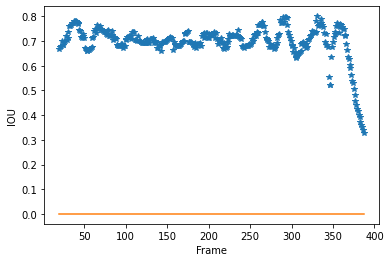

In [44]:
out1 = lstm_20.predict(x)
out = bb_intersection_over_union_np(out1,y)
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], np.squeeze(out),'*')
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], ped[j]['abnormal']*0.02 )
plt.xlabel('Frame')
plt.ylabel('IOU')
print(np.mean(out))

In [46]:
out.shape

(1, 1, 368, 1)

In [55]:
ExtremaAndPersistence = RunPersistence(np.squeeze(out))


In [56]:
Filtered = [t for t in ExtremaAndPersistence if t[1] > 3]


In [57]:
Sorted = sorted(Filtered, key=lambda ExtremumAndPersistence: ExtremumAndPersistence[1])


In [58]:
for i, E in enumerate(Sorted):
#     strType = "Minimum" if (i % 2 == 0) else "Maximum"
#     print("%s at index %d with persistence %g and data value %g" % (strType, E[0], E[1], InputData[E[0]]))
    print(i)
    print(E)
    print("*"*20)

0
(367, inf)
********************


In [18]:
iou_sum = []
for j in ped.keys():
    x,y = norm_train_max_min(data_dict=ped[j], max1 = max1, min1=min1 )
    out1 = lstm_20.predict(x)
    out = bb_intersection_over_union_np(out1,y)
    iou_sum.append([np.mean(out), np.any(ped[j]['abnormal']) ])
iou_sum = np.array(iou_sum)

In [19]:
np.mean(iou_sum[:,0])

0.21909486332635988

In [20]:
iou_sum

array([[6.97541952e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [7.15556017e-01, 0.00000000e+00],
       [6.36544946e-01, 0.00000000e+00],
       [1.65291476e-03, 1.00000000e+00],
       [5.14549594e-02, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [1.40179016e-01, 0.00000000e+00],
       [5.59192029e-01, 0.00000000e+00],
       [2.34315872e-01, 0.00000000e+00],
       [5.75262642e-03, 1.00000000e+00],
       [6.60494271e-01, 0.00000000e+00],
       [1.85320738e-01, 0.00000000e+00],
       [2.17956989e-01, 0.00000000e+00],
       [2.27702563e-01, 0.00000000e+00],
       [3.33693940e-01, 0.00000000e+00],
       [2.42306380e-01, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00],
       [1.62673685e-03, 0.00000000e+00],
       [9.13120851e-02, 1.00000000e+00],
       [4.67914516e-01, 0.00000000e+00],
       [2.17259506e-05, 0.00000000e+00],
       [1.62435594e-01, 0.00000000e+00],
       [1.99741113e-01, 0.00000000e+00],
       [2.790763

In [106]:
abnormal_ped = iou_sum[np.nonzero(iou_sum[:,1])]

In [107]:
norm_ped = iou_sum[np.where(iou_sum[:,1]==0)]

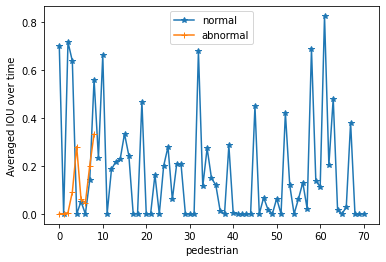

In [108]:
plt.plot(norm_ped[:,0],'-*', label='normal')
plt.plot(abnormal_ped[:,0], '-+', label='abnormal')
plt.xlabel('pedestrian')
plt.ylabel('Averaged IOU over time')
plt.legend()

In [109]:
iou_sum[:4][0]

array([0.69754195, 0.        ])

In [45]:
bb_intersection_over_union_np(lstm_20.predict(xx_norm), yy_norm, True)

-0.29737979486318383

In [46]:
bb_intersection_over_union_np(lstm_20.predict(xx_abnorm), yy_abnorm, True)

-0.07336282689540416

Text(0, 0.5, 'IOU')

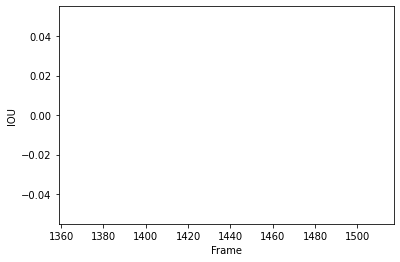

In [47]:
out1 = lstm_20.predict(x)
out = norm_train_max_min(data=out1, max1 = max1,min1 =min1,undo_norm=True)
out = bb_intersection_over_union_np(out,ped[j]['y_ppl_box'])
plt.plot(ped[j]['frame_ppl_id'][:,-1,0], np.squeeze(out),'-')

plt.xlabel('Frame')
plt.ylabel('IOU')

In [ ]:
ped['1']['y_ppl_box']

# Figuring out IOU error 

In [ ]:
# bb_intersection_over_union_np(np.array([[10.,20.,22.,12.]]), np.array([[18.,24.,22.,18.]]))
# bb_intersection_over_union_np(np.array([[10.,12.,22.,20.]]), np.array([[18.,18.,22.,24.]]))

bb_intersection_over_union_np(np.array([[10.,12.,22.,20.]])*5, np.array([[18.,8.,22.,14.]])*5)

In [ ]:
bb_intersection_over_union_np(np.array([[39., 63., 203., 112.]]), np.array([[54., 66., 198., 114.]]))

In [ ]:
[39, 63, 203, 112], [54, 66, 198, 114]

In [ ]:
bb_intersection_over_union_np(np.array([[10,12,22,20]]), np.array([[18,8,22,14]]))

In [ ]:
np.array([18,8,22,14])*5

In [ ]:
np.array([[10,12,22,20]])*5

# K means

In [18]:
xx_test,yy_test= norm_train_max_min(data_dict = testdict, max1=max1,min1=min1)


In [ ]:
y_pred_scal = model.predict(xx_test)
y_pred = norm_train_max_min(data=y_pred_scal, max1 = max1,min1 =min1,undo_norm=True)

In [ ]:
kmean_scal = KMeans(n_clusters=2)
kmean = KMeans(n_clusters=2)

In [ ]:
def tlbr_xywh(data):
    data = data.astype(float)
    data[:,2] = np.abs(data[:,2] - data[:,0] )
    data[:,3] = np.abs(data[:,3] - data[:,1])
    
    data[:,0] = data[:,0] + data[:,2]/2
    data[:,1] = data[:,1] + data[:,3]/2
  
    
    return data

In [ ]:
tlbr_xywh(y_pred)

In [ ]:
kmean_scal.fit(tlbr_xywh(y_pred_scal)[:,0:2])
kmean.fit(tlbr_xywh(y_pred)[:,0:2])

In [ ]:
out = kmean_scal.cluster_centers_
out

In [ ]:
out1 = kmean.cluster_centers_
out1

In [ ]:
plt.scatter(tlbr_xywh(y_pred_scal)[:,0], tlbr_xywh(y_pred_scal)[:,1],s=1, c='b')
plt.scatter(out[0,0], out[0,1],s=200, c ='g', marker='s')
plt.scatter(out[1,0], out[1,1], s=200, c ='r', marker='s')

In [ ]:
plt.scatter(tlbr_xywh(y_pred)[:,0], tlbr_xywh(y_pred)[:,1],s=1, c='b')
plt.scatter(out1[0,0], out1[0,1],s=200, c ='g', marker='s')
plt.scatter(out1[1,0], out1[1,1], s=200, c ='r', marker='s')

# Using X Difference

In [ ]:
j = '12'
out = model.predict(ped[j]['x_ppl_box'])
out = norm_train_max_min(data=out, max1 = max1,min1 =min1,undo_norm=True)
out = tlbr_xywh(out)

In [ ]:
out

In [ ]:
xy_diff = []
for i in range(1,len(out)):
    
    xy_diff.append(out[i,:] - out[i-1,:])

xy_diff = np.array(xy_diff)
out =np.sum(np.square(xy_diff[:,0:2]), axis=1)
    

In [ ]:
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], out,'-')
plt.plot(ped[j]['frame_ppl_id'][1:,-1,0],ped[j]['abnormal'][1:]*1000 )
# plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], xy_diff[:,0],'-+')
# plt.plot(ped[j]['frame_ppl_id'][1:,-1,0], xy_diff[:,1],'-0')
plt.xlabel('Frame')